# Sample real-time EEG notebook

In [1]:
%matplotlib qt

In [2]:
from mne import set_log_level
from mne.time_frequency import psd_multitaper

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt

import rteeg

set_log_level(verbose='error')

In [3]:
rt = rteeg.Stream()

## Start the stream

In [4]:
rt.connect(eeg=True, markers=True, eeg_montage='Enobio32')

Searching for EEG stream ... 
Searching for Markers stream ... 
Connected to EEG stream. 
Connected to Markers stream. 


In [5]:
# See which streams are active.
rt.active_streams

{'eeg': True, 'markers': True}

## Visualize the data

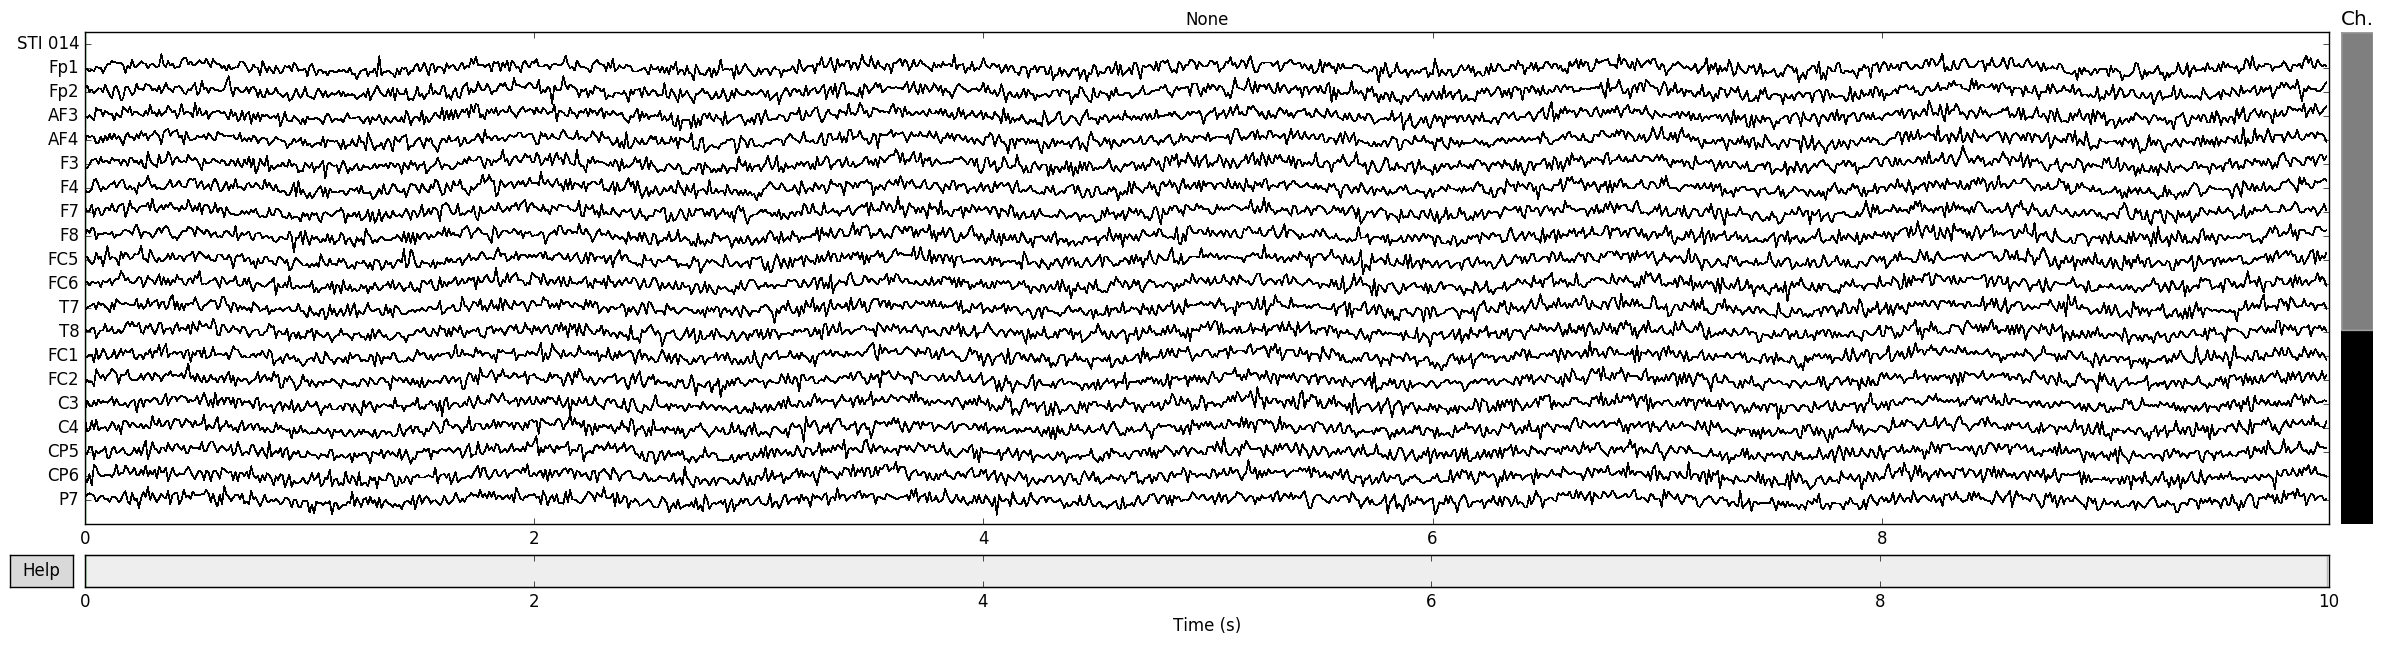

In [7]:
# Get the last 10 seconds of data and plot.
temp_raw = rt.make_raw(10)
temp_raw.plot(scalings='auto')

## Fit ICA on the upcoming X seconds of data

Alternatively, user can input data (as `mne.io.Raw` object) on which to perform ICA.

Use
---

Fit ICA once --> select bad components --> apply ICA to all incoming data

ICA only has to be fitted once. Once the ICA has been fitted, user can plot the ICA sources and select the bad components by clicking on them. Once the plot is closed, the bad components will be stored in the `exclude` attribute of the ICA object (i.e., `rt.mne_ica.exclude`). Call the `apply()` method of the ICA object to remove bad components from the EEG data (e.g., `rt.mne_ica.apply(raw)`).

In [8]:
rt.fit_ica(10)

[........................................] 100.00000 | Collecting data   
Computing ICA solution ...
Finished in 0.76 s


<ICA  |  raw data decomposition, fit (extended-infomax): 1000 samples, 32 components, channels used: "eeg">

In [ ]:
# Plot ICA components over time and select the noisy ones.
rt.viz_ica()

In [ ]:
print("Component(s) {} marked as bad.".format(rt.mne_ica.exclude))

# Apply ICA to the data on which it was fitted to ensure that 
# removing the specified component(s) does not mess up the data.
rt.mne_ica.apply(rt.mne_raw_for_ica.copy()).plot(scalings='auto')

## Example of analysis in one function

In [ ]:
def analysis(data_duration, verbose='error'):
    """Analysis from start to finish for one chunk of data."""
    # Get raw data.
    raw = rt.make_raw(data_duration)
    
    # High- and low-pass filter.
    raw.filter(l_freq=0.5, h_freq=None, phase='zero', fir_window='hamming', 
               l_trans_bandwidth='auto', h_trans_bandwidth='auto', 
               filter_length='auto', verbose=verbose)
    raw.filter(l_freq=None, h_freq=40., phase='zero', fir_window='hamming', 
               l_trans_bandwidth='auto', h_trans_bandwidth='auto', 
               filter_length='auto', verbose=verbose)
        
    # Calculate power.
    psds, freqs = psd_multitaper(raw_ica, fmin=0.5, fmax=13.0, verbose='error')
    
    # PCA of the power. These steps would be slightly different if using Epochs.
    X = psds.flatten()
    X = X[None,:]
    X = StandardScaler().fit_transform(X)
    X = PCA(n_components=15).fit_transform(X)
    
    return X

    # # Feed X into a classifier clf.
    # y = clf.predict(X)
    # return y

In [ ]:
analysis(30)

## Timing tests of `analysis()`

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

timeit_results = {
    'data_duration': [1, 5, 10, 20, 30, 60, 90, 120, 180, 240, 300, 360],
    'time_taken': [66.9, 92.3, 121, 123, 181, 341, 510, 680, 1005, 1380, 1690, 2100]
}

x = np.array(timeit_results['data_duration'])
y = np.array(timeit_results['time_taken'])
m, b = np.polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-')

print("Formula for line of best fit:")
print("(time taken) = {}*(data duration) + {}".format(m, b))

# Analysis step by step (assuming ICA has been fitted)

## Get most recent data

In [ ]:
# Get the last 30 seconds of data
raw = rt.make_mne_raw(30)
raw.plot(scalings='auto')

### Filter

In [ ]:
# High- and low-pass filter separately.
# This is done in-place.
raw.filter(l_freq=0.5, h_freq=None, phase='zero', fir_window='hamming', 
           l_trans_bandwidth='auto', h_trans_bandwidth='auto', 
           filter_length='auto')
raw.filter(l_freq=None, h_freq=40., phase='zero', fir_window='hamming', 
           l_trans_bandwidth='auto', h_trans_bandwidth='auto', 
           filter_length='auto')

### ICA

In [ ]:
raw_ica = rt.mne_ica.apply(raw)
raw_ica.plot(scalings='auto')

### Feature extraction

Calculate power, then perform PCA on power to reduce number of features.

In [ ]:
psds, freqs = psd_multitaper(raw_ica, fmin=0.5, fmax=13.0)
print psds.shape
# Array is 2D if made from raw object, but 3D if made from epochs object.

In [ ]:
# X = psds.reshape(len(psds), -1)  # Convert from 3D to 2D.
X = psds.flatten()
X = X[None,:]
X = StandardScaler().fit_transform(X)
X = PCA(n_components=15).fit_transform(X)
print X.shape